## Setup:

In [1]:
!git clone https://github.com/mat10d/EvolvePro.git
%cd EvolvePro/

Cloning into 'EvolvePro'...
remote: Enumerating objects: 1322, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1322 (delta 14), reused 19 (delta 9), pack-reused 1287 (from 2)
Receiving objects: 100% (1322/1322), 85.04 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (722/722), done.
/content/EvolvePro


In [2]:
!pip install pandas numpy scikit-learn scikit-learn-extra xgboost matplotlib seaborn biopython scipy torch fair-esm openpyxl
!mkdir /content/output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/

## Get embeddings from sequence

In [3]:
from evolvepro.src.process import generate_wt, generate_single_aa_mutants

## Define sequence
protein_name = 'kelsic'
wt_protein_sequence = 'MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR'

## Define file outpaths
wt_fasta_path = f'/content/output/{protein_name}_WT.fasta'
mut_fasta_path = f'/content/output/{protein_name}.fasta'

## Process sequence
generate_wt(wt_protein_sequence, output_file=wt_fasta_path)
generate_single_aa_mutants(wt_fasta_path, output_file=mut_fasta_path)

Number of mutants: 1369


In [4]:
## Suggest initial mutants for testing
from evolvepro.src.process import suggest_initial_mutants
suggest_initial_mutants(mut_fasta_path, num_mutants=12, random_seed=42)


Suggested 12 mutants for testing:
1. R23K
2. T58E
3. I36D
4. V31C
5. I7A
6. K3F
7. Q10P
8. G38E
9. E4M
10. D61W
11. E4Y
12. R23N


In [17]:
## Specify model to use for embedding
import os, sys
'''
ESM models for use:
    esm2_t6_8M_UR50D (8 million parameters)
    esm2_t12_35M_UR50D (35 million parameters)
    esm2_t30_150M_UR50D (150 million parameters)
    esm2_t36_3B_UR50D (3 billion parameters)
    esm2_t48_15B_UR50D (15 billion parameters)
'''
model_name = 'esm2_t6_8M_UR50D'

## Extract mean embeddings
input_fasta_path = f'/content/output/{protein_name}.fasta'
embeddings_file_lead = f'{protein_name}_{model_name}'
embeddings_base_path = '/content/output'
os.system(f'python evolvepro/plm/esm/extract.py {model_name} {input_fasta_path} {embeddings_base_path}/{embeddings_file_lead} --toks_per_batch 512 --include mean --concatenate_dir {embeddings_base_path}')


0

## Reclass

In [19]:
import pandas as pd
from typing import List, Dict, Any, Optional, Tuple
import os, sys
import pandas as pd
import numpy as np
import random

In [20]:
## Augment data
n_predictions = 5
round_files = [f'colab/rounds_data/kelsic_Round{i}.xlsx' for i in range(1, 6)]
for file_name in round_files:
    ## Read df
    df = pd.read_excel(file_name)
    ## Adjust column names
    columns = df.columns
    columns = ['Variant', 'activity_0']
    df.columns = columns
    ## Add additional random predictions
    for i in range(1, n_predictions):
        df[f'activity_{i}'] = np.random.rand(len(df))
    df.to_excel(file_name[:-5] + '_aug' + '.xlsx', index=False)
    print(file_name[:-5] + '_aug' + '.xlsx')


colab/rounds_data/kelsic_Round1_aug.xlsx
colab/rounds_data/kelsic_Round2_aug.xlsx
colab/rounds_data/kelsic_Round3_aug.xlsx
colab/rounds_data/kelsic_Round4_aug.xlsx
colab/rounds_data/kelsic_Round5_aug.xlsx


In [24]:
from evolvepro.src.data import load_dms_data, load_experimental_embeddings, load_experimental_data, create_iteration_dataframes
from evolvepro.src.utils import pca_embeddings
from evolvepro.src.model import first_round, top_layer


''' Adjustments to evolve_experimental to suppress print statements'''
def evolve_experimental(
    protein_name : str,
    round_name : str,
    embeddings_base_path : str,
    embeddings_file_name : str,
    round_base_path : str,
    round_file_names : List[str],
    wt_fasta_path : str,
    rename_WT : bool = False,
    number_of_variants : int = 12,
    output_dir : str = '/orcd/archive/abugoot/001/Projects/Matteo/Github/EvolvePro/output/exp_results/'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    """
    Perform one round of directed evolution for a protein.

    Args:
    protein_name (str): Name of the protein.
    round_name (str): Name of the current round (e.g., 'Round1').
    embeddings_base_path (str): Base path for embeddings file.
    embeddings_file_name (str): Name of the embeddings file.
    round_base_path (str): Base path for round data files.
    round_file_names (list): List of round file names.
    wt_fasta_path (str): Path to the wild-type FASTA file.
    rename_WT (bool): Whether to rename the wild-type.
    number_of_variants (int): Number of top variants to display.
    output_dir (str): Directory to save output files.

    Returns:
    tuple: (this_round_variants, df_test, df_sorted_all)
    """

    # Load embeddings
    embeddings = load_experimental_embeddings(embeddings_base_path, embeddings_file_name, rename_WT)

    # Load experimental data
    all_experimental_data = []
    for round_file_name in round_file_names:
        experimental_data = load_experimental_data(round_base_path, round_file_name, wt_fasta_path)
        all_experimental_data.append(experimental_data)

    # Create iteration dataframes
    iteration, labels = create_iteration_dataframes(all_experimental_data, embeddings.index)

    # Perform top layer analysis
    this_round_variants, df_test, df_sorted_all = top_layer(
        iter_train=iteration['iteration'].unique().tolist(),
        iter_test=None,
        embeddings_pd=embeddings,
        labels_pd=labels,
        measured_var='activity',
        regression_type='randomforest',
        experimental=True
    )

    # Save results if an output_dir is provided
    if output_dir is not None:
        output_dir = os.path.join(output_dir, protein_name, round_name)
        os.makedirs(output_dir, exist_ok=True)
        iteration.to_csv(os.path.join(output_dir, 'iteration.csv'))
        this_round_variants.to_csv(os.path.join(output_dir, 'this_round_variants.csv'))
        df_test = df_test.sort_values(by=['y_pred'], ascending=False)
        df_test.to_csv(os.path.join(output_dir, 'df_test.csv'))
        df_sorted_all.to_csv(os.path.join(output_dir, 'df_sorted_all.csv'))
        print(f"\nData saved to {output_dir}")

    return this_round_variants, df_test, df_sorted_all

'''Wrapper to run evolve_experimental multiple times for each individual attribute'''
def mh_evolve_experimental(
        protein_name : str,
        round_name : str,
        embeddings_base_path : str,
        embeddings_file_name : str,
        round_base_path : str,
        round_file_names : List[str],
        wt_fasta_path : str,
        rename_WT : bool = False,
        number_of_variants : int = 12,
        activity_opt : dict = None,
        output_dir : str = '/orcd/archive/abugoot/001/Projects/Matteo/Github/EvolvePro/output/exp_results/',
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    ## Export to individual excel files
    activities_dir = f'{round_base_path}/activities'
    os.makedirs(activities_dir, exist_ok=True)
    activities_file_name_dict = {}
    for round_file_name in round_file_names:
        df = pd.read_excel(f'{round_base_path}/{round_file_name}')
        activity_cols = [i for i in df.columns if i != 'Variant']
        ## Iterate across non-variant columns
        for col in activity_cols:
            val_df = df[['Variant', col]]
            val_df.columns = ['Variant', 'activity']
            val_df_filename = f'{round_file_name[:-5]}_{col}.xlsx'
            val_df.to_excel(f'{activities_dir}/{val_df_filename}', index=False)
            activities_file_name_dict[col] = activities_file_name_dict[col] + [val_df_filename] if col in activities_file_name_dict.keys() else [val_df_filename]

    total_dfs = None
    for activity in activities_file_name_dict.keys():
        print(f'Processing {activity}')
        ## Get activity filenames
        activity_file_names = activities_file_name_dict[activity]

        ## Run experimental evolution
        this_round_variants, df_test, df_sorted_all = evolve_experimental(
        protein_name,
        round_name,
        embeddings_base_path,
        embeddings_file_name,
        activities_dir,
        activity_file_names,
        wt_fasta_path,
        rename_WT,
        number_of_variants,
        output_dir=None,
        )

        ## Calculate rank of variant
        ascending=False
        if activity_opt and activity in activity_opt.keys():
            ascending = False if activity_opt[activity] == 'max' else True
        if activity_opt and activity not in activity_opt.keys():
            print(f'{activity} not in activity_opt. Setting default to "maximum" optimization')
        df_sorted_all['rank'] = df_sorted_all['y_pred'].rank(ascending=ascending, method='dense')

        ## Add to list
        total_dfs = pd.concat([total_dfs, df_sorted_all.set_index('variant').add_suffix(f'_{activity}')], axis=1)

    ## Calculate combined rank
    total_dfs.reset_index(inplace=True)
    rank_cols = [i for i in total_dfs.columns if i.__contains__('rank')]
    total_dfs['Sum_rank'] = total_dfs[rank_cols].sum(axis=1)
    total_dfs = total_dfs.sort_values(by=['Sum_rank'], ascending=True)

    # Print results
    print(f"\nTested variants in this round: {len(this_round_variants)}")
    print(this_round_variants)
    print(f"\nTop {number_of_variants} variants predicted by the model:")
    print(total_dfs.sort_values(by=['Sum_rank'], ascending=True).head(number_of_variants)[['variant', 'Sum_rank']])

    ## make df_test
    train_cols = [i for i in total_dfs.columns if i.__contains__('y_actual')]

    # Save results if an output_dir is provided
    if output_dir is not None:
        output_dir = os.path.join(output_dir, protein_name, round_name)
        os.makedirs(output_dir, exist_ok=True)
        this_round_variants.to_csv(os.path.join(output_dir, 'this_round_variants.csv'))
        total_dfs[total_dfs[train_cols].isna()].to_csv(os.path.join(output_dir, 'df_test.csv'))
        total_dfs.to_csv(os.path.join(output_dir, 'df_sorted_all.csv'))
        print(f"\nData saved to {output_dir}")

    return this_round_variants, total_dfs[total_dfs[train_cols].isna()], total_dfs

## Run EVOLVEpro

In [25]:
embeddings_file_name = f'{embeddings_file_lead}.csv'
round_base_path = 'colab/rounds_data'
number_of_variants = 12
output_dir = embeddings_base_path + '/'
rename_WT = False

## Round 1

In [26]:
round_name = 'Round1'
round_file_names = [f'{protein_name}_Round1_aug.xlsx']
activity_opt = {'activity_0': 'max',
                 'activity_1': 'max',
                 'activity_2': 'max',
                 'activity_3': 'min',
                 'activity_4': 'min'}

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir,
)

Processing activity_0
Embeddings and labels are aligned
(1357,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Embeddings and labels are aligned
(1357,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Embeddings and labels are aligned
(1357,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Embeddings and labels are aligned
(1357,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Embeddings and labels are aligned
(1357,)

Tested variants in this round: 12
50      I36D
310     T58E
429      E4M
519      K3F
531     V31C
557     G38E
573     Q10P
632     R23K
770     D61W
835     R23N
1128     I7A
1355     E4Y
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant  Sum_rank
348    R23N     435.0
105    P59C     722.0
8      R72C     804.0
198    R41H     955.0
257    G65N     955.0
22     R70C     957.0
1       E4M     973.0
79     V55C     992.0
64     E27N     999.0
269    R72H    1105.0
411    R66H    1120.0
309    R70H    1191.0

Data saved to /content/output/kelsic/Round1


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


#### Round 2

In [27]:
round_name = 'Round2'
round_file_names = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx']

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir,
)

Processing activity_0
Embeddings and labels are aligned
(1345,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Embeddings and labels are aligned
(1345,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Embeddings and labels are aligned
(1345,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Embeddings and labels are aligned
(1345,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Embeddings and labels are aligned
(1345,)

Tested variants in this round: 24
50      I36D
169     S71C
278      E4H
305      E4V
310     T58E
429      E4M
455      E4L
457      E8Q
519      K3F
531     V31C
557     G38E
573     Q10P
632     R23K
645      E4N
679      E4F
732     T12M
754     T12C
770     D61W
835     R23N
853      E4Q
992      D5M
1009     E8C
1128     I7A
1355     E4Y
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant  Sum_rank
274    R23N     572.0
4       E4M    1248.0
2       E4N    1249.0
13      E4Q    1263.0
0       E4F    1318.0
9      E27T    1415.0
20     V31C    1426.0
323    R72N    1469.0
426    G65Q    1470.0
180    I45C    1472.0
16     E27N    1519.0
267     I7N    1534.0

Data saved to /content/output/kelsic/Round2


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


#### Round 3

In [28]:
round_name = 'Round3'
round_file_names = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx',
                    f'{protein_name}_Round3_aug.xlsx']

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir,
)

Processing activity_0
Embeddings and labels are aligned
(1333,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Embeddings and labels are aligned
(1333,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Embeddings and labels are aligned
(1333,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Embeddings and labels are aligned
(1333,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Embeddings and labels are aligned
(1333,)

Tested variants in this round: 36
50      I36D
169     S71C
174      E4W
198      D5V
223      D5L
278      E4H
282      D5Y
305      E4V
310     T58E
363      D5N
429      E4M
455      E4L
457      E8Q
519      K3F
531     V31C
557     G38E
564      E4C
568      E4I
573     Q10P
632     R23K
645      E4N
679      E4F
732     T12M
754     T12C
770     D61W
835     R23N
838     E25Q
853      E4Q
933      M1W
971      D5C
992      D5M
1009     E8C
1051     D5F
1064     D5I
1128     I7A
1355     E4Y
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant  Sum_rank
0       D5F     554.0
720    R23N    1102.0
17      E4M    1180.0
18      E4Q    1204.0
193    D61T    1221.0
1       D5I    1228.0
61     D61H    1247.0
397    D61Q    1273.0
415    V55H    1290.0
6       D5L    1293.0
40     E27N    1308.0
14      D5Q    1323.0

Data saved to /content/output/kelsic/Round3


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


#### Round 4

In [29]:
round_name = 'Round4'
round_file_names = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx',
                    f'{protein_name}_Round3_aug.xlsx', f'{protein_name}_Round4_aug.xlsx']

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir,
)

Processing activity_0
Embeddings and labels are aligned
(1321,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Embeddings and labels are aligned
(1321,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Embeddings and labels are aligned
(1321,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Embeddings and labels are aligned
(1321,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Embeddings and labels are aligned
(1321,)

Tested variants in this round: 48
50      I36D
101      E4T
169     S71C
174      E4W
198      D5V
223      D5L
278      E4H
282      D5Y
305      E4V
310     T58E
317     M21L
352      D5H
363      D5N
429      E4M
455      E4L
457      E8Q
487     E27M
519      K3F
531     V31C
557     G38E
564      E4C
568      E4I
570     E27C
573     Q10P
612      D5S
618      D5A
632     R23K
645      E4N
679      E4F
707     V24I
732     T12M
754     T12C
770     D61W
835     R23N
838     E25Q
849      D5T
853      E4Q
874      D5Q
933      M1W
971      D5C
992      D5M
1009     E8C
1051     D5F
1064     D5I
1074    E27Q
1109    E27L
1128     I7A
1355     E4Y
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant  Sum_rank
1       D5F     276.0
433    R23N     634.0
26      E4Q     835.0
16      E4M     909.0
2       D5I     990.0
14      E4Y    1133.0
43      E4K    1153.0
359    R66H    1185.0
114    S6

/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


#### Round 5

In [30]:
round_name = 'Round5'
round_file_names = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx',
                    f'{protein_name}_Round3_aug.xlsx', f'{protein_name}_Round4_aug.xlsx',
                    f'{protein_name}_Round5_aug.xlsx']

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir,
)

Processing activity_0
Embeddings and labels are aligned
(1309,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Embeddings and labels are aligned
(1309,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Embeddings and labels are aligned
(1309,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Embeddings and labels are aligned
(1309,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Embeddings and labels are aligned
(1309,)

Tested variants in this round: 60
50      I36D
75      V55I
101      E4T
169     S71C
174      E4W
198      D5V
223      D5L
278      E4H
282      D5Y
305      E4V
310     T58E
317     M21L
352      D5H
363      D5N
429      E4M
455      E4L
457      E8Q
487     E27M
519      K3F
531     V31C
540     S71K
557     G38E
564      E4C
568      E4I
570     E27C
573     Q10P
612      D5S
614      E8H
618      D5A
632     R23K
645      E4N
679      E4F
691      E4S
707     V24I
726     T20H
732     T12M
753      E4P
754     T12C
770     D61W
829     Q10H
835     R23N
838     E25Q
840      E4A
849      D5T
853      E4Q
874      D5Q
933      M1W
956      D5W
963      E8F
971      D5C
992      D5M
1009     E8C
1051     D5F
1064     D5I
1074    E27Q
1109    E27L
1128     I7A
1234     D5P
1308     E8K
1355     E4Y
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant  Sum_rank
1       D5F     506.0
16     

/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


## Round 6

In [31]:
best_mutant = 'E25Q'

## Generate mutant string
mut_protein_sequence = None
str_pos = int(best_mutant[1:-1])+1
if wt_protein_sequence[str_pos] != best_mutant[0]:
    raise AttributeError('Mutant not formatted correctly or not in sequence')
else:
    mut_protein_sequence = wt_protein_sequence[:str_pos] + best_mutant[-1] + wt_protein_sequence[str_pos+1:]

print(f'wt> {wt_protein_sequence}')
print(' ' * (str_pos + 4) + '*')
print(f'mt> {mut_protein_sequence}')

wt> MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR
                              *
mt> MAKEDNIEMQGTVLETLPNTMFRVELQNGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR


In [38]:
## Make 2ndary embeddings from best mutant
from evolvepro.src.evolve import evolve_experimental_multi
from evolvepro.src.process import generate_wt, generate_single_aa_mutants

## Define sequence
mut_protein_name = f'kelsic_{best_mutant}'

## Define file outpaths
mwt_fasta_path = f'/content/output/{mut_protein_name}_WT.fasta'
mmut_fasta_path = f'/content/output/{mut_protein_name}.fasta'

## Process sequence
generate_wt(mut_protein_sequence, output_file=mwt_fasta_path)
generate_single_aa_mutants(mwt_fasta_path, output_file=mmut_fasta_path)

## Extract mean embeddings
print('Extracting embeddings...')
embeddings_file_lead = f'{mut_protein_name}_{model_name}_round6'
embeddings_base_path = '/content/output'
os.system(f'python evolvepro/plm/esm/extract.py {model_name} {mmut_fasta_path} {embeddings_base_path}/{embeddings_file_lead} --toks_per_batch 512 --include mean --concatenate_dir {embeddings_base_path}')


Number of mutants: 1369
Extracting embeddings...


0

In [39]:
'''Remove print statements and add prefix to multi variants with updated labelling'''
def evolve_experimental_multi(
    protein_name: str,
    round_name: str,
    embeddings_base_path: str,
    embeddings_file_names: List[str],
    round_base_path: str,
    round_file_names_single: List[str],
    round_file_names_multi: List[str],
    wt_fasta_path: str,
    rename_WT: bool = False,
    number_of_variants: int = 12,
    output_dir: str = '/orcd/archive/abugoot/001/Projects/Matteo/Github/EvolvePro/output/exp_results/'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Perform one round of directed evolution for a protein with multi-mutant support.
    """
    print(f"Processing {protein_name} - {round_name}")

    # Load and concatenate multiple embedding files
    embeddings_list = []
    for i, file_name in enumerate(embeddings_file_names):
        embedding = load_experimental_embeddings(embeddings_base_path, file_name, rename_WT)
        if i > 0:  # If not the first file
            embedding.index = [f'mut{i}_' + ei for ei in list(embedding.index)]
        embeddings_list.append(embedding)

    embeddings = pd.concat(embeddings_list)
    print(f"Embeddings loaded: {embeddings.shape}")

    # Load experimental data
    all_experimental_data = []
    for round_file_name in round_file_names_single:
        experimental_data = load_experimental_data(round_base_path, round_file_name, wt_fasta_path, single_mutant=True)
        all_experimental_data.append(experimental_data)
        print(f"Loaded experimental data for {round_file_name}: {experimental_data.shape}")

    for ri, round_file_name in enumerate(round_file_names_multi):
        experimental_data = load_experimental_data(round_base_path, round_file_name, wt_fasta_path, single_mutant=True)
        experimental_data['updated_variant'] = f'mut{ri}' + experimental_data['updated_variant']
        all_experimental_data.append(experimental_data)
        print(f"Loaded experimental data for {round_file_name}: {experimental_data.shape}")

    all_experimental_data = [pd.concat(all_experimental_data)]

    # Create iteration dataframes
    iteration, labels = create_iteration_dataframes(all_experimental_data, embeddings.index)

    # Perform top layer analysis
    this_round_variants, df_test, df_sorted_all = top_layer(
        iter_train=iteration['iteration'].unique().tolist(),
        iter_test=None,
        embeddings_pd=embeddings,
        labels_pd=labels,
        measured_var='activity',
        regression_type='randomforest',
        experimental=True
    )

    # Save results if an output_dir is provided
    if output_dir is not None:
        output_dir = os.path.join(output_dir, protein_name, round_name)
        os.makedirs(output_dir, exist_ok=True)
        iteration.to_csv(os.path.join(output_dir, 'iteration.csv'))
        this_round_variants.to_csv(os.path.join(output_dir, 'this_round_variants.csv'))
        df_test = df_test.sort_values(by=['y_pred'], ascending=False)
        df_test.to_csv(os.path.join(output_dir, 'df_test.csv'))
        df_sorted_all.to_csv(os.path.join(output_dir, 'df_sorted_all.csv'))
        print(f"\nData saved to {output_dir}")

    return this_round_variants, df_test, df_sorted_all


'''Wrapper to run evolve_experimental multiple times for each individual attribute'''
def mh_evolve_experimental_multi(
        protein_name : str,
        round_name : str,
        embeddings_base_path : str,
        embeddings_file_names: List[str],
        round_base_path: str,
        round_file_names_single: List[str],
        round_file_names_multi: List[str],
        wt_fasta_path : str,
        rename_WT : bool = False,
        number_of_variants : int = 12,
        activity_opt : dict = None,
        output_dir : str = '/orcd/archive/abugoot/001/Projects/Matteo/Github/EvolvePro/output/exp_results/',
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    ## Export to individual excel files
    activities_dir = f'{round_base_path}/activities'
    os.makedirs(activities_dir, exist_ok=True)
    activities_file_name_dict = {0: {},
                                1: {}}
    for ri, round_file_names in enumerate([round_file_names_single, round_file_names_multi]):
        for round_file_name in round_file_names:
            df = pd.read_excel(f'{round_base_path}/{round_file_name}')
            activity_cols = [i for i in df.columns if i != 'Variant']
            ## Iterate across non-variant columns
            for col in activity_cols:
                val_df = df[['Variant', col]]
                val_df.columns = ['Variant', 'activity']
                val_df_filename = f'{round_file_name[:-5]}_{col}.xlsx'
                val_df.to_excel(f'{activities_dir}/{val_df_filename}', index=False)
                activities_file_name_dict[ri][col] = activities_file_name_dict[col] + [val_df_filename] if col in activities_file_name_dict.keys() else [val_df_filename]

    total_dfs = None
    for activity in activities_file_name_dict[0].keys():
        print(f'Processing {activity}')
        ## Get activity filenames
        activity_file_names_single = activities_file_name_dict[0][activity]
        activity_file_names_multi = activities_file_name_dict[1][activity]

        ## Run experimental evolution
        this_round_variants, df_test, df_sorted_all = evolve_experimental_multi(
        protein_name,
        round_name,
        embeddings_base_path,
        embeddings_file_names,
        activities_dir,
        activity_file_names_single,
        activity_file_names_multi,
        wt_fasta_path,
        rename_WT,
        number_of_variants,
        output_dir=None,
        )

        ## Calculate rank of variant
        ascending=False
        if activity_opt and activity in activity_opt.keys():
            ascending = False if activity_opt[activity] == 'max' else True
        if activity_opt and activity not in activity_opt.keys():
            print(f'{activity} not in activity_opt. Setting default to "maximum" optimization')
        df_sorted_all['rank'] = df_sorted_all['y_pred'].rank(ascending=ascending, method='dense')

        ## Add to list
        total_dfs = pd.concat([total_dfs, df_sorted_all.set_index('variant').add_suffix(f'_{activity}')], axis=1)

    ## Calculate combined rank
    total_dfs.reset_index(inplace=True)
    rank_cols = [i for i in total_dfs.columns if i.__contains__('rank')]
    total_dfs['Sum_rank'] = total_dfs[rank_cols].sum(axis=1)
    total_dfs = total_dfs.sort_values(by=['Sum_rank'], ascending=True)

    # Print results
    print(f"\nTested variants in this round: {len(this_round_variants)}")
    print(this_round_variants)
    print(f"\nTop {number_of_variants} variants predicted by the model:")
    print(total_dfs.sort_values(by=['Sum_rank'], ascending=True).head(number_of_variants)[['variant', 'Sum_rank']])

    ## make df_test
    train_cols = [i for i in total_dfs.columns if i.__contains__('y_actual')]

    # Save results if an output_dir is provided
    if output_dir is not None:
        output_dir = os.path.join(output_dir, protein_name, round_name)
        os.makedirs(output_dir, exist_ok=True)
        this_round_variants.to_csv(os.path.join(output_dir, 'this_round_variants.csv'))
        total_dfs[total_dfs[train_cols].isna()].to_csv(os.path.join(output_dir, 'df_test.csv'))
        total_dfs.to_csv(os.path.join(output_dir, 'df_sorted_all.csv'))
        print(f"\nData saved to {output_dir}")

    return this_round_variants, total_dfs[total_dfs[train_cols].isna()], total_dfs


In [41]:
# Multivariant
embeddings_file_name_1 = f'{protein_name}_{model_name}.csv'
embeddings_file_name_2 = f'{mut_protein_name}_{model_name}.csv'

round_name = 'Round6'
round_file_names_single = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx',
                    f'{protein_name}_Round3_aug.xlsx', f'{protein_name}_Round4_aug.xlsx']
round_file_names_multi = [f'{protein_name}_Round5_aug.xlsx']

rename_WT = True

this_round_variants, df_test, df_sorted_all = mh_evolve_experimental_multi(
    protein_name,
    round_name,
    embeddings_base_path,
    [embeddings_file_name_1, embeddings_file_name_2],
    round_base_path,
    round_file_names_single,
    round_file_names_multi,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    activity_opt,
    output_dir
)

Processing activity_0
Processing kelsic - Round6
Embeddings loaded: (2738, 320)
Loaded experimental data for kelsic_Round4_aug_activity_0.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5_aug_activity_0.xlsx: (12, 3)
Embeddings and labels are aligned
(2726,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_1
Processing kelsic - Round6
Embeddings loaded: (2738, 320)
Loaded experimental data for kelsic_Round4_aug_activity_1.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5_aug_activity_1.xlsx: (12, 3)
Embeddings and labels are aligned
(2726,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_2
Processing kelsic - Round6
Embeddings loaded: (2738, 320)
Loaded experimental data for kelsic_Round4_aug_activity_2.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5_aug_activity_2.xlsx: (12, 3)
Embeddings and labels are aligned
(2726,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_3
Processing kelsic - Round6
Embeddings loaded: (2738, 320)
Loaded experimental data for kelsic_Round4_aug_activity_3.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5_aug_activity_3.xlsx: (12, 3)
Embeddings and labels are aligned
(2726,)


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


Processing activity_4
Processing kelsic - Round6
Embeddings loaded: (2738, 320)
Loaded experimental data for kelsic_Round4_aug_activity_4.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5_aug_activity_4.xlsx: (12, 3)
Embeddings and labels are aligned
(2726,)

Tested variants in this round: 12
101      E4T
317     M21L
352      D5H
487     E27M
570     E27C
612      D5S
618      D5A
707     V24I
849      D5T
874      D5Q
1074    E27Q
1109    E27L
Name: variant, dtype: object

Top 12 variants predicted by the model:
        variant  Sum_rank
1014       N28K    1294.0
1038       N28M    1898.0
236         N6H    1947.0
587        N28H    2029.0
563        S63H    2104.0
54         S37H    2214.0
1018       N28A    2253.0
538        N28E    2357.0
338        N19P    2371.0
273        F69H    2468.0
1649  mut1_N19H    2621.0
260        S37R    2713.0

Data saved to /content/output/kelsic/Round6


/content/EvolvePro/evolvepro/src/model.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


## Plot

In [46]:
os.getcwd()

'/content/EvolvePro'

In [49]:
from evolvepro.src.plot import read_exp_data, plot_variants_by_iteration

round_base_path = 'colab/rounds_data'
round_file_names = [f'{protein_name}_Round1_aug.xlsx', f'{protein_name}_Round2_aug.xlsx',
                    f'{protein_name}_Round3_aug.xlsx', f'{protein_name}_Round4_aug.xlsx',
                    f'{protein_name}_Round5_aug.xlsx']
wt_fasta_path = "/content/output/kelsic_WT.fasta"

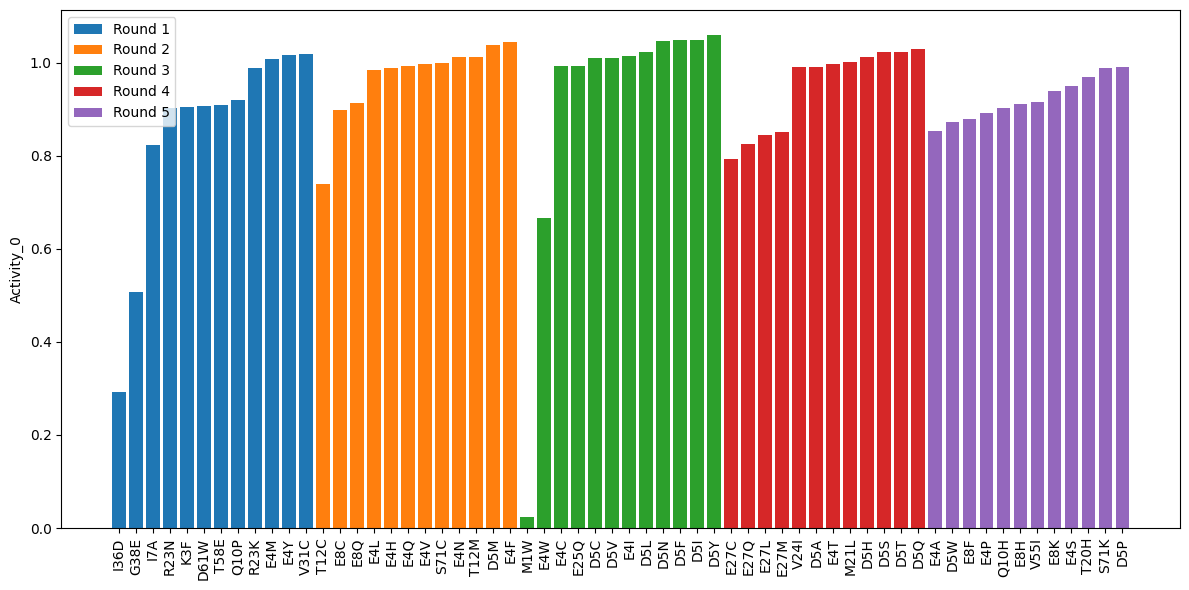

In [50]:
df = read_exp_data(round_base_path, round_file_names, wt_fasta_path)
plot_variants_by_iteration(df, activity_column='activity_0', output_dir=output_dir, output_file="kelsic")


Text(0.5, 0, 'EvolvePRO Round')

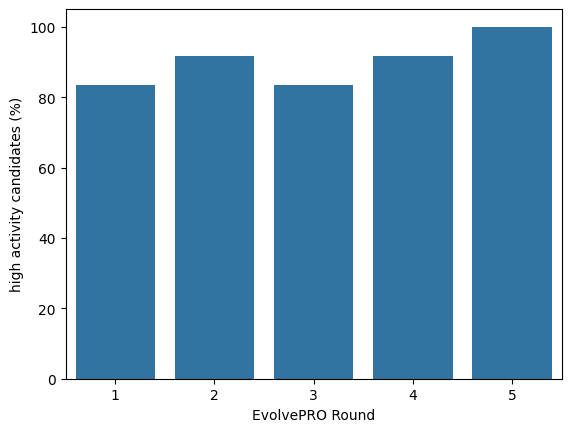

In [51]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Calculate % high activity variants
high_activity_threshold = 0.8
percentages = (
    df.assign(flag=df["activity_0"] > high_activity_threshold)  # Create a boolean flag
    .groupby("iteration")["flag"]
    .mean()  # Compute the mean, which gives the percentage
    .mul(100)  # Convert to percentage
    .reset_index()
    .rename(columns={"flag": "percentage"})
)
## Plot
sns.barplot(data=percentages, x='iteration', y='percentage')
plt.ylabel('high activity candidates (%)')
plt.xlabel('EvolvePRO Round')
